# Comparison of longitudinal distribtions
- Measured MD4224 tomoscope data (around 140 ns)
- PyORBIT generated (via measured) tomo (138 ns)
- BLonD generated (note this gives a smaller bunch of ~125 ns)

In [1]:
import os
import re
import sys
import subprocess
import numpy as np
import scipy.io as sio
from scipy.io import savemat
import matplotlib.pyplot as plt

### Functions

In [2]:
def make_directory(path):
    try:
        os.mkdir(path)
    except OSError:
        print ("Creation of the directory %s failed" % path)
    else:
        print ("Successfully created the directory %s " % path)  

In [3]:
def add_input_file(dd, filename, label):
	f = filename
	p = dict()
	sio.loadmat(f, mdict=p)
	dd[label] = p
	print '\tAdded output data from ', filename, '\t dictionary key: ', label
	return dd

In [4]:
def t_from_z(z, beta=0.9158):
    return ((z)/(1E-9 * 299792458 * beta))

def z_from_t(t, beta=0.9158):
    return (t * 1e-9) * 299792458 * beta

In [5]:
def bin_edges_to_centres(bin_edges):
    bin_width = np.abs(bin_edges[1] - bin_edges[0])    
    half_bin_width = bin_width/2.
    
    bin_centres_ = []
    
    for be in bin_edges:
        bin_centres_.append(be-half_bin_width)
    
    bin_centres = np.array(bin_centres_[:-1])
    
    return bin_centres   

In [6]:
make_directory('Comparison_Plots')

Creation of the directory Comparison_Plots failed


### Run tomo executable to bin tomo data
- fully explained in Generate_PyORBIT_Tomo_File.ipynb

In [7]:
input_file_name='../../00_Longitudinal_Distribution/C200_001_001_002.dat'
input_file_path=input_file_name

result = subprocess.Popen(['./tomo_vo.intelmp'], stdin=open(input_file_path, 'r'), stdout=subprocess.PIPE, stderr=subprocess.PIPE)
out, err = result.communicate()
out = out.splitlines()

dat = np.loadtxt("image002.data") # This name may be different, please check if it doesnt work

var = (int(np.sqrt(dat.shape[0])), int(np.sqrt(dat.shape[0])))
dat = dat.reshape(var).T

print(out[7])
print(out[9])

# formatter for output (out) binsizes
regexp = re.compile("\\d+\\.?\\d*E?[-+]?\\d*")

# Save in units of nanoseconds and mega electron volts
dt = float(regexp.findall(out[7])[0])/1E-9 # ns
dE = float(regexp.findall(out[9])[0])/1E6  # MeV

# make bins
tAxis = np.arange(dat.shape[0])*dt
EAxis = np.arange(dat.shape[0])*dE

# centre on (0,0) - not exact
tAxis -= np.mean(tAxis)
EAxis -= np.mean(EAxis)

tAxis += 8	#MD4224 Vertical 1

filter_level = 5E-5

for x,y in np.ndindex(dat.shape):
	if dat[x,y] < filter_level:					# 1.3 eVs
		dat[x,y] = 0.0	
		
# This filters any pixel where surrounding pixels are 0
# may need to be modified if your phase space isn't a bunch but
# contains some sort of lines / filamentation that is wanted
for x in range (0, dat.shape[0], 1):
	for y in range( 0, dat.shape[1], 1):
		if x == 0 or y == 0 or x == (dat.shape[0]-1) or y == (dat.shape[1]-1) or dat[x,y] == 0.0:
			pass
		else: 
			if dat[x, y-1] == 0.0 and dat[x, y+1] == 0.0:
				print 'outlier removed at [',x, ',' ,y, ']'
				dat[x,y] = 0.0
                
# We need to turn a 2D numpy array (matrix) into 2 1D histograms
dE_hist = []
dt_hist = []

bins_x = dat.shape[0]
bins_y = dat.shape[1]

dE_slice = 0.

for x_b in xrange(bins_x):
    dE_slice = 0.
    for y_b in xrange(bins_y):
        dE_slice = dE_slice + dat[x_b, y_b]
            
    dE_hist.append(dE_slice)
    
for y_b in xrange(bins_y):
    dt_slice = 0.
    for x_b in xrange(bins_x):
        dt_slice = dt_slice + dat[x_b, y_b]
            
    dt_hist.append(dt_slice)

 dtbin = 2.5000E-09
 dEbin = 1.4344E+05
outlier removed at [ 24 , 27 ]
outlier removed at [ 25 , 25 ]
outlier removed at [ 27 , 23 ]
outlier removed at [ 47 , 89 ]
outlier removed at [ 48 , 80 ]
outlier removed at [ 52 , 1 ]
outlier removed at [ 52 , 89 ]
outlier removed at [ 54 , 88 ]
outlier removed at [ 55 , 3 ]
outlier removed at [ 58 , 85 ]
outlier removed at [ 66 , 14 ]


### Plot normalised histograms from tomo

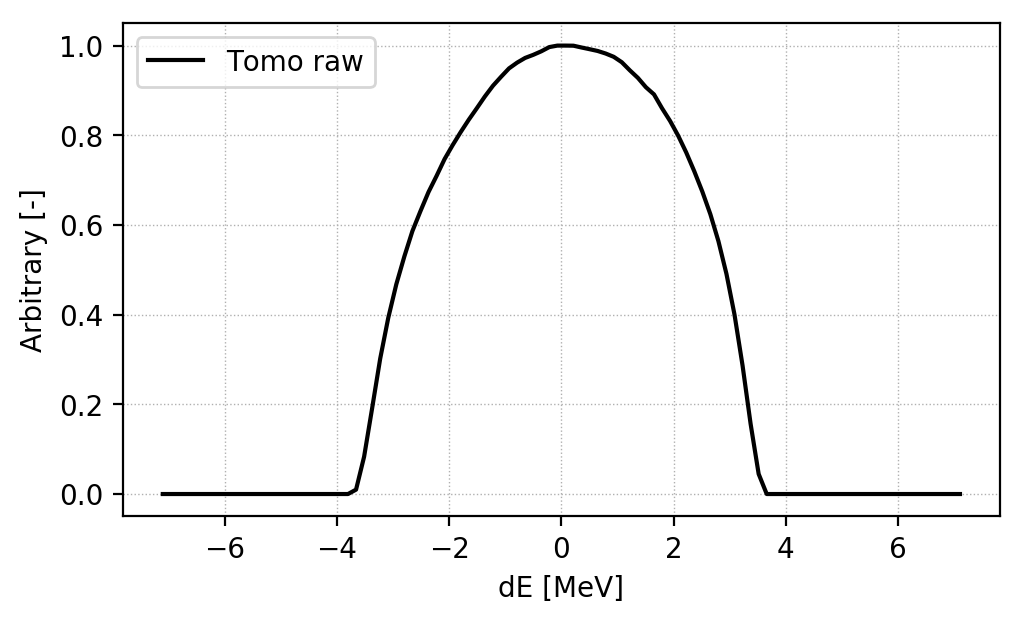

In [8]:
fig1 = plt.figure(figsize=(5, 3), dpi= 200, facecolor='w', edgecolor='k', constrained_layout=True);
ax1 = fig1.add_subplot(111);
    
norm = 1./np.max(dE_hist);
dE_hist2 = np.multiply(dE_hist, norm);
ax1.plot(EAxis, dE_hist2, label = 'Tomo raw', color='k');
         
ax1.set_xlabel('dE [MeV]');
ax1.set_ylabel('Arbitrary [-]');
ax1.grid(which='both', ls=':', lw=0.5);
ax1.legend(loc=2);


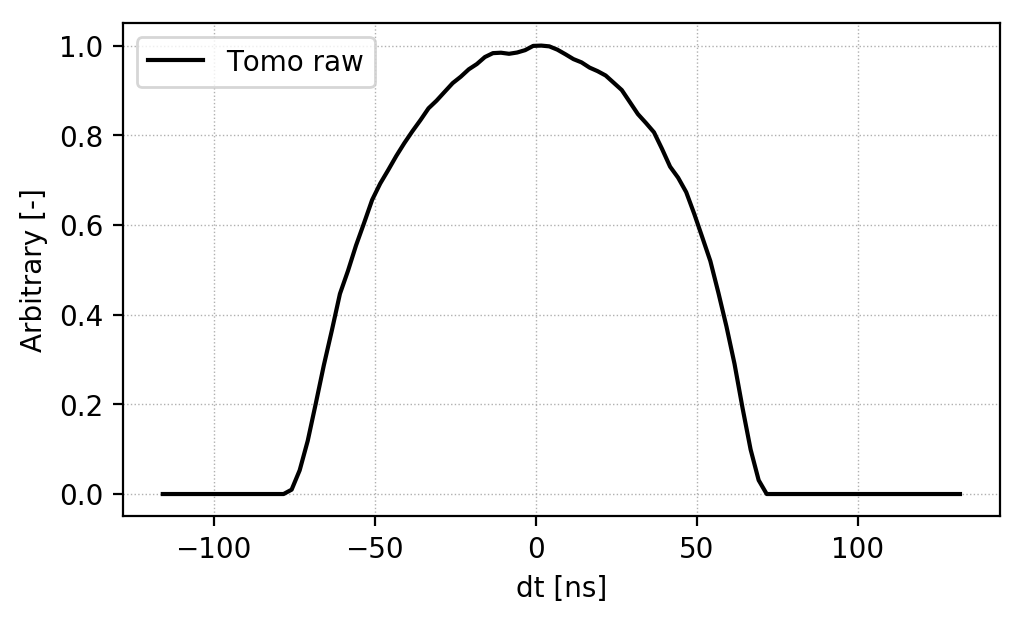

In [9]:
fig1 = plt.figure(figsize=(5, 3), dpi= 200, facecolor='w', edgecolor='k', constrained_layout=True);
ax1 = fig1.add_subplot(111);

normt = 1./np.max(dt_hist);
dt_hist2 = np.multiply(dt_hist, normt);
ax1.plot(tAxis, dt_hist2, label = 'Tomo raw', color='k');

ax1.set_xlabel('dt [ns]');
ax1.set_ylabel('Arbitrary [-]');
ax1.grid(which='both', ls=':', lw=0.5);
ax1.legend(loc=2);


# Load initial distribution file from PyORBIT
- located in ../../01_Generate_Initial_Distribution/500000/0_H_21/bunch_output/mainbunch_-000001.mat

In [10]:
pyorbit_file = "../../01_Generate_Initial_Distribution/500000/0_H_21/bunch_output/mainbunch_-000001.mat"

particles = sio.loadmat(pyorbit_file, squeeze_me=True,  struct_as_record=False)['particles']
PO_z  = particles.z         # default metres
PO_dE = particles.dE *1E3   # default GeV

PO_t_ = []
for z in PO_z:
    PO_t_.append(t_from_z(z))
    
PO_t = np.array(PO_t_)

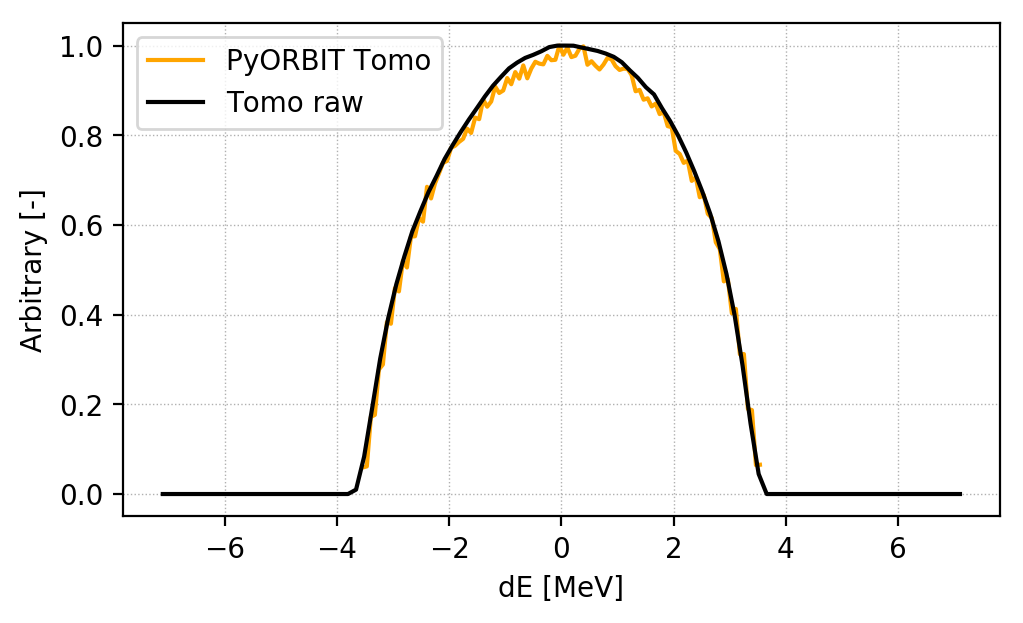

In [11]:
fig1 = plt.figure(figsize=(5, 3), dpi= 200, facecolor='w', edgecolor='k', constrained_layout=True);
ax1 = fig1.add_subplot(111);
    
PO_dE_hist, PO_dE_edges  = np.histogram(PO_dE, bins = bins_x, density=True)
norm_PO = 1./np.max(PO_dE_hist);
PO_dE_hist2 = np.multiply(PO_dE_hist, norm_PO);
ax1.plot(bin_edges_to_centres(PO_dE_edges), PO_dE_hist2, label = 'PyORBIT Tomo', color='orange');

norm = 1./np.max(dE_hist);
dE_hist2 = np.multiply(dE_hist, norm);
ax1.plot(EAxis, dE_hist2, label = 'Tomo raw', color='k');
         
ax1.set_xlabel('dE [MeV]');
ax1.set_ylabel('Arbitrary [-]');
ax1.grid(which='both', ls=':', lw=0.5);
ax1.legend(loc=2);

fig1.savefig('Comparison_Plots/dE_comparison_tomo.png')

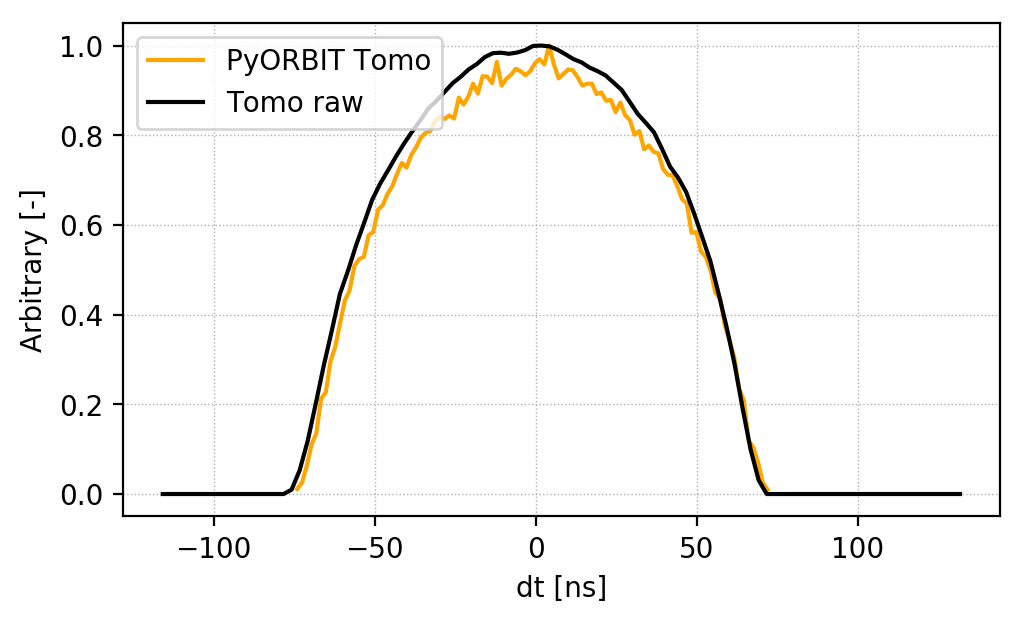

In [12]:
fig1 = plt.figure(figsize=(5, 3), dpi= 200, facecolor='w', edgecolor='k', constrained_layout=True);
ax1 = fig1.add_subplot(111);
    
PO_dt_hist, PO_dt_edges  = np.histogram(PO_t, bins = bins_y, density=True)
norm_POt = 1./np.max(PO_dt_hist);
PO_dt_hist2 = np.multiply(PO_dt_hist, norm_POt);
ax1.plot(bin_edges_to_centres(PO_dt_edges), PO_dt_hist2, label = 'PyORBIT Tomo', color='orange');

normt = 1./np.max(dt_hist);
dt_hist2 = np.multiply(dt_hist, normt);
ax1.plot(tAxis, dt_hist2, label = 'Tomo raw', color='k');
         
ax1.set_xlabel('dt [ns]');
ax1.set_ylabel('Arbitrary [-]');
ax1.grid(which='both', ls=':', lw=0.5);
ax1.legend(loc=2);

fig1.savefig('Comparison_Plots/dt_comparison_tomo.png')

### Load BLonD data and PyORBIT BlonD distribution

In [13]:
pyorbit_file = "../../01_Generate_Initial_Distribution_BLonD/500000/0_V_24/bunch_output/mainbunch_-000001.mat"

particles = sio.loadmat(pyorbit_file, squeeze_me=True,  struct_as_record=False)['particles']
POB_z  = particles.z         # default metres
POB_dE = particles.dE *1E3   # default GeV

POB_t_ = []
for z in POB_z:
    POB_t_.append(t_from_z(z))
    
POB_t = np.array(POB_t_)

In [14]:
blond_file = '../../00_Longitudinal_SC_V_RF/BLonD_Longitudinal_Distributions/BLonD_Longitudinal_Distn_MD4224_21p2kV.npz'
BLonD_data = np.load(blond_file)      
BL_z = BLonD_data['dz']
BL_dE = (BLonD_data['dE']/ 1E6)

BL_t_ = []
for z in BL_z:
    BL_t_.append(t_from_z(z))
    
BL_t = np.array(BL_t_)

### Load space charge matched distribuitions

In [15]:
pyorbit_file = "../../01_Generate_Initial_Distribution_BLonD/500000/1_V_24/bunch_output/mainbunch_-000001.mat"

particles = sio.loadmat(pyorbit_file, squeeze_me=True,  struct_as_record=False)['particles']
POB2_z  = particles.z         # default metres
POB2_dE = particles.dE *1E3   # default GeV

POB2_t_ = []
for z in POB2_z:
    POB2_t_.append(t_from_z(z))
    
POB2_t = np.array(POB2_t_)

In [16]:
blond_file = '../../00_Longitudinal_SC_V_RF/BLonD_Longitudinal_Distributions/BLonD_Longitudinal_Distn_MD4224_18p2kV.npz'
BLonD_data = np.load(blond_file)      
BL2_z = BLonD_data['dz']
BL2_dE = (BLonD_data['dE']/ 1E6)

BL2_t_ = []
for z in BL2_z:
    BL2_t_.append(t_from_z(z))
    
BL2_t = np.array(BL2_t_)

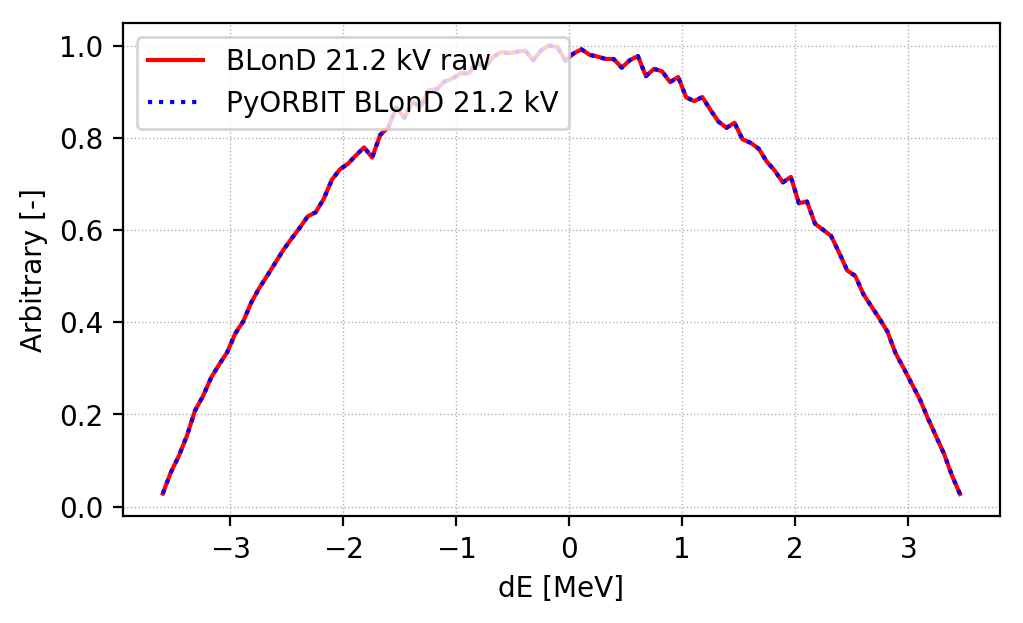

In [17]:
fig1 = plt.figure(figsize=(5, 3), dpi= 200, facecolor='w', edgecolor='k', constrained_layout=True);
ax1 = fig1.add_subplot(111);

BL_dE_hist, BL_dE_edges  = np.histogram(BL_dE, bins = bins_x, density=True)
norm_BL = 1./np.max(BL_dE_hist);
BL_dE_hist2 = np.multiply(BL_dE_hist, norm_BL);
ax1.plot(bin_edges_to_centres(BL_dE_edges), BL_dE_hist2, label = 'BLonD 21.2 kV raw', color='r'); 

POB_dE_hist, POB_dE_edges  = np.histogram(POB_dE, bins = bins_x, density=True)
norm_POB = 1./np.max(POB_dE_hist);
POB_dE_hist2 = np.multiply(POB_dE_hist, norm_POB);
ax1.plot(bin_edges_to_centres(POB_dE_edges), POB_dE_hist2, label = 'PyORBIT BLonD 21.2 kV', ls=':', color='b');     
         
ax1.set_xlabel('dE [MeV]');
ax1.set_ylabel('Arbitrary [-]');
ax1.grid(which='both', ls=':', lw=0.5);
ax1.legend(loc=2);

fig1.savefig('Comparison_Plots/dE_comparison_BLonD.png')

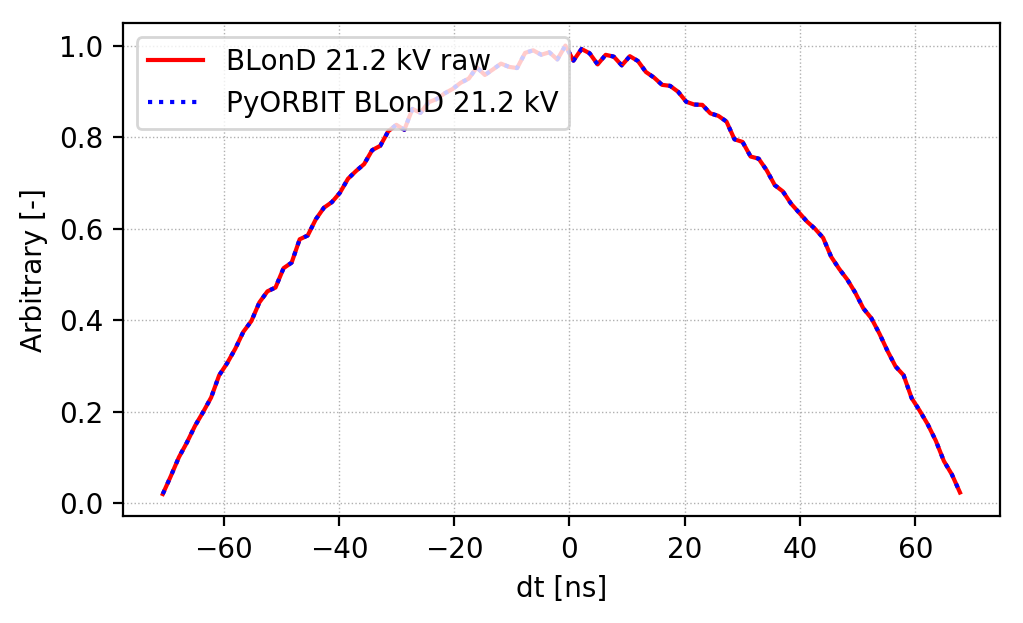

In [18]:
fig1 = plt.figure(figsize=(5, 3), dpi= 200, facecolor='w', edgecolor='k', constrained_layout=True);
ax1 = fig1.add_subplot(111);

BL_dt_hist, BL_dt_edges  = np.histogram(BL_t, bins = bins_y, density=True)
norm_BLt = 1./np.max(BL_dt_hist);
BL_dt_hist2 = np.multiply(BL_dt_hist, norm_BLt);
ax1.plot(bin_edges_to_centres(BL_dt_edges), BL_dt_hist2, label = 'BLonD 21.2 kV raw', color='r');

POB_dt_hist, POB_dt_edges  = np.histogram(POB_t, bins = bins_y, density=True)
norm_POBt = 1./np.max(POB_dt_hist);
POB_dt_hist2 = np.multiply(POB_dt_hist, norm_POBt);
ax1.plot(bin_edges_to_centres(POB_dt_edges), POB_dt_hist2, label = 'PyORBIT BLonD 21.2 kV', ls=':', color='b');  
       
ax1.set_xlabel('dt [ns]');
ax1.set_ylabel('Arbitrary [-]');
ax1.grid(which='both', ls=':', lw=0.5);
ax1.legend(loc=2);

fig1.savefig('Comparison_Plots/dt_comparison_BLonD.png')

## Plot all comparisons

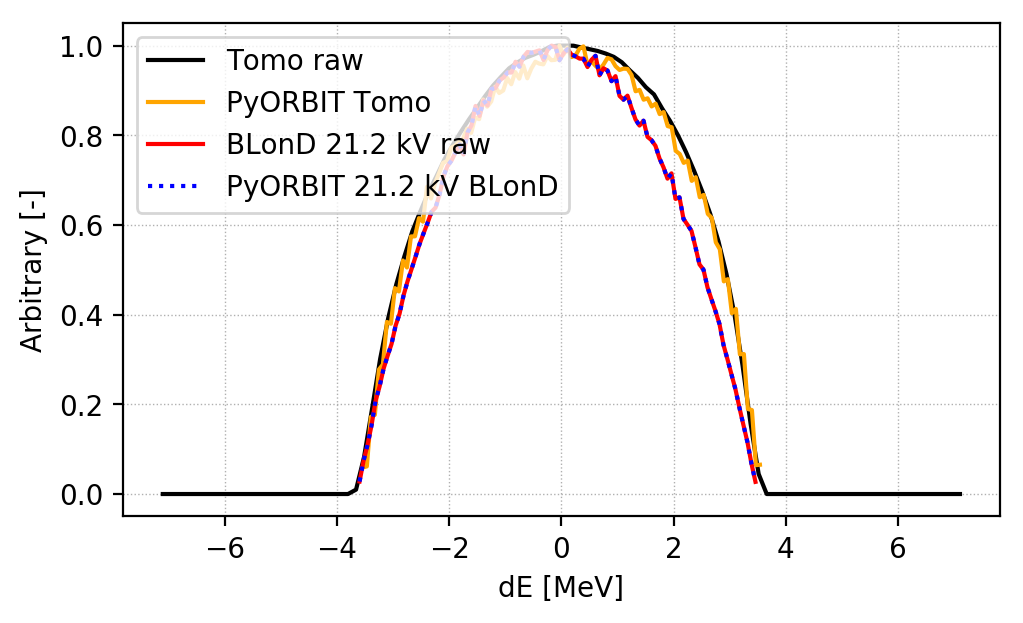

In [19]:
fig1 = plt.figure(figsize=(5, 3), dpi= 200, facecolor='w', edgecolor='k', constrained_layout=True);
ax1 = fig1.add_subplot(111);
 
norm = 1./np.max(dE_hist);
dE_hist2 = np.multiply(dE_hist, norm);
ax1.plot(EAxis, dE_hist2, label = 'Tomo raw', color='k'); 

PO_dE_hist, PO_dE_edges  = np.histogram(PO_dE, bins = bins_x, density=True)
norm_PO = 1./np.max(PO_dE_hist);
PO_dE_hist2 = np.multiply(PO_dE_hist, norm_PO);
ax1.plot(bin_edges_to_centres(PO_dE_edges), PO_dE_hist2, label = 'PyORBIT Tomo', color='orange'); 

BL_dE_hist, BL_dE_edges  = np.histogram(BL_dE, bins = bins_x, density=True)
norm_BL = 1./np.max(BL_dE_hist);
BL_dE_hist2 = np.multiply(BL_dE_hist, norm_BL);
ax1.plot(bin_edges_to_centres(BL_dE_edges), BL_dE_hist2, label = 'BLonD 21.2 kV raw', color='r');

POB_dE_hist, POB_dE_edges  = np.histogram(POB_dE, bins = bins_x, density=True)
norm_POB = 1./np.max(POB_dE_hist);
POB_dE_hist2 = np.multiply(POB_dE_hist, norm_POB);
ax1.plot(bin_edges_to_centres(POB_dE_edges), POB_dE_hist2, label = 'PyORBIT 21.2 kV BLonD', ls=':', color='b');   
         
ax1.set_xlabel('dE [MeV]');
ax1.set_ylabel('Arbitrary [-]');
ax1.grid(which='both', ls=':', lw=0.5);
ax1.legend(loc=2);

fig1.savefig('Comparison_Plots/dE_comparison_all.png')

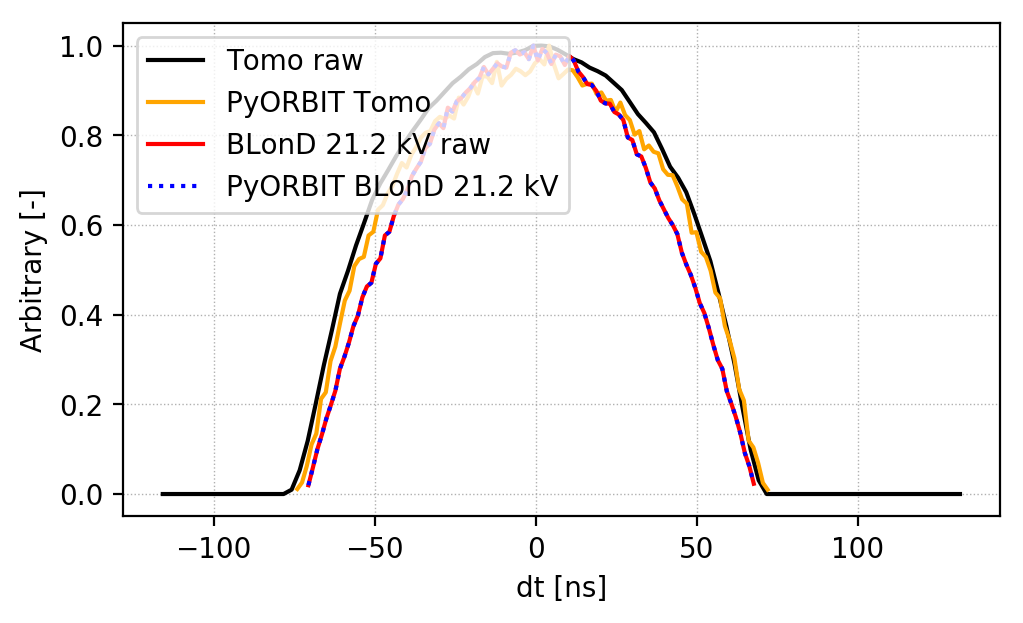

In [20]:
fig1 = plt.figure(figsize=(5, 3), dpi= 200, facecolor='w', edgecolor='k', constrained_layout=True);
ax1 = fig1.add_subplot(111);

normt = 1./np.max(dt_hist);
dt_hist2 = np.multiply(dt_hist, normt);
ax1.plot(tAxis, dt_hist2, label = 'Tomo raw', color='k');

PO_dt_hist, PO_dt_edges  = np.histogram(PO_t, bins = bins_y, density=True)
norm_POt = 1./np.max(PO_dt_hist);
PO_dt_hist2 = np.multiply(PO_dt_hist, norm_POt);
ax1.plot(bin_edges_to_centres(PO_dt_edges), PO_dt_hist2, label = 'PyORBIT Tomo', color='orange');

BL_dt_hist, BL_dt_edges  = np.histogram(BL_t, bins = bins_y, density=True)
norm_BLt = 1./np.max(BL_dt_hist);
BL_dt_hist2 = np.multiply(BL_dt_hist, norm_BLt);
ax1.plot(bin_edges_to_centres(BL_dt_edges), BL_dt_hist2, label = 'BLonD 21.2 kV raw', color='r');

POB_dt_hist, POB_dt_edges  = np.histogram(POB_t, bins = bins_y, density=True)
norm_POBt = 1./np.max(POB_dt_hist);
POB_dt_hist2 = np.multiply(POB_dt_hist, norm_POBt);
ax1.plot(bin_edges_to_centres(POB_dt_edges), POB_dt_hist2, label = 'PyORBIT BLonD 21.2 kV', ls=':', color='b'); 
       
ax1.set_xlabel('dt [ns]');
ax1.set_ylabel('Arbitrary [-]');
ax1.grid(which='both', ls=':', lw=0.5);
ax1.legend(loc=2);

fig1.savefig('Comparison_Plots/dt_comparison_all.png')

# Plot raw data only

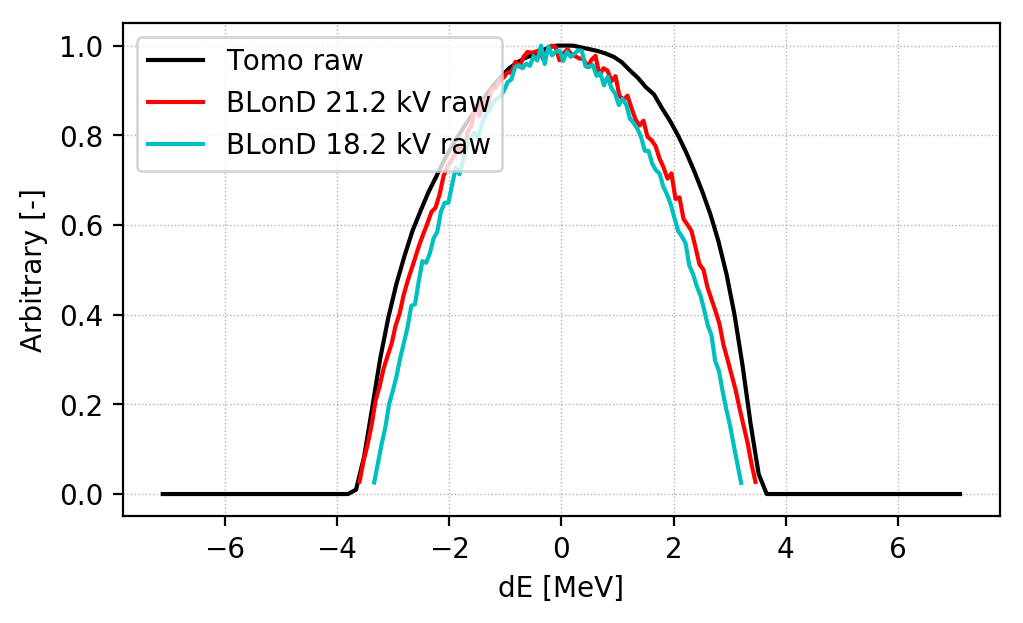

In [21]:
fig1 = plt.figure(figsize=(5, 3), dpi= 200, facecolor='w', edgecolor='k', constrained_layout=True);
ax1 = fig1.add_subplot(111);
 
norm = 1./np.max(dE_hist);
dE_hist2 = np.multiply(dE_hist, norm);
ax1.plot(EAxis, dE_hist2, label = 'Tomo raw', color='k'); 

BL_dE_hist, BL_dE_edges  = np.histogram(BL_dE, bins = bins_x, density=True)
norm_BL = 1./np.max(BL_dE_hist);
BL_dE_hist2 = np.multiply(BL_dE_hist, norm_BL);
ax1.plot(bin_edges_to_centres(BL_dE_edges), BL_dE_hist2, label = 'BLonD 21.2 kV raw', color='r'); 

BL2_dE_hist, BL2_dE_edges  = np.histogram(BL2_dE, bins = bins_x, density=True)
norm_BL2 = 1./np.max(BL2_dE_hist);
BL2_dE_hist2 = np.multiply(BL2_dE_hist, norm_BL2);
ax1.plot(bin_edges_to_centres(BL2_dE_edges), BL2_dE_hist2, label = 'BLonD 18.2 kV raw', color='c'); 

ax1.set_xlabel('dE [MeV]');
ax1.set_ylabel('Arbitrary [-]');
ax1.grid(which='both', ls=':', lw=0.5);
ax1.legend(loc=2);

fig1.savefig('Comparison_Plots/dE_comparison_raw.png')

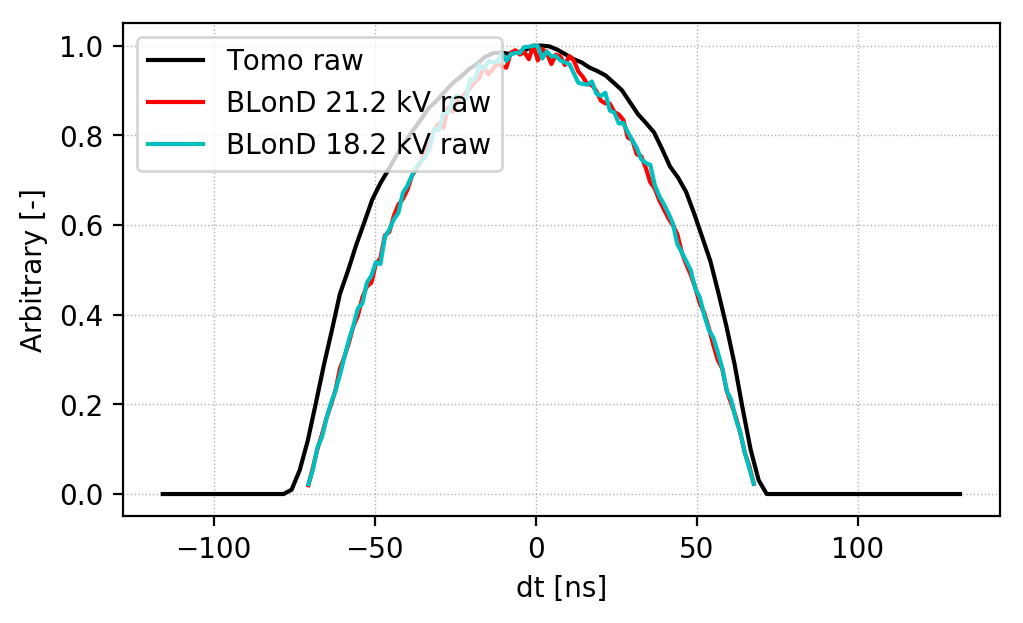

In [22]:
fig1 = plt.figure(figsize=(5, 3), dpi= 200, facecolor='w', edgecolor='k', constrained_layout=True);
ax1 = fig1.add_subplot(111);

normt = 1./np.max(dt_hist);
dt_hist2 = np.multiply(dt_hist, normt);
ax1.plot(tAxis, dt_hist2, label = 'Tomo raw', color='k');

BL_dt_hist, BL_dt_edges  = np.histogram(BL_t, bins = bins_y, density=True)
norm_BLt = 1./np.max(BL_dt_hist);
BL_dt_hist2 = np.multiply(BL_dt_hist, norm_BLt);
ax1.plot(bin_edges_to_centres(BL_dt_edges), BL_dt_hist2, label = 'BLonD 21.2 kV raw', color='r');

BL2_dt_hist, BL2_dt_edges  = np.histogram(BL2_t, bins = bins_y, density=True)
norm_BL2t = 1./np.max(BL2_dt_hist);
BL2_dt_hist2 = np.multiply(BL2_dt_hist, norm_BL2t);
ax1.plot(bin_edges_to_centres(BL2_dt_edges), BL2_dt_hist2, label = 'BLonD 18.2 kV raw', color='c');
       
ax1.set_xlabel('dt [ns]');
ax1.set_ylabel('Arbitrary [-]');
ax1.grid(which='both', ls=':', lw=0.5);
ax1.legend(loc=2);

fig1.savefig('Comparison_Plots/dt_comparison_raw.png')

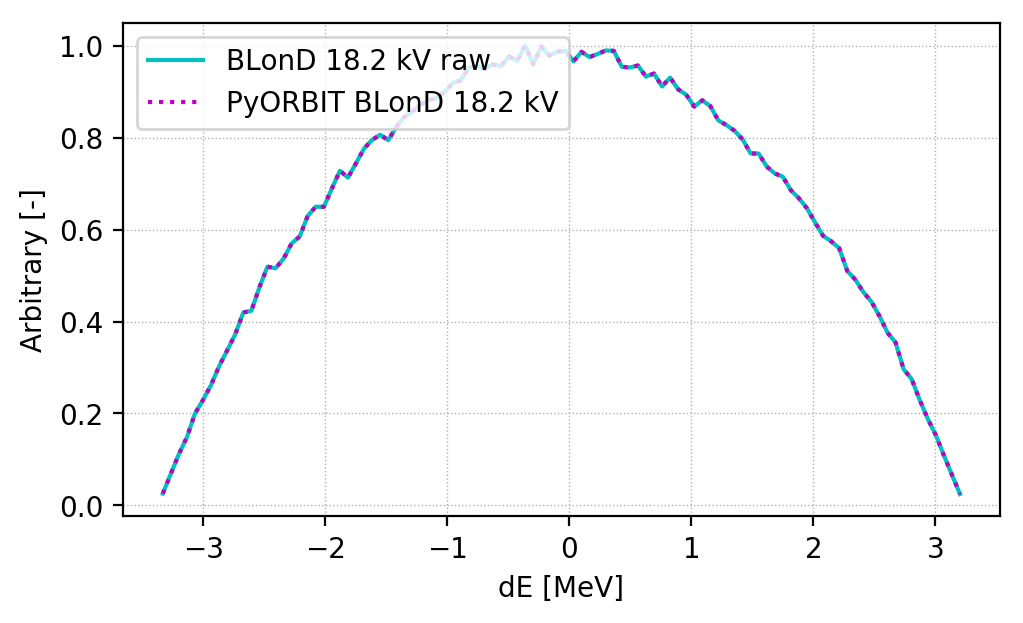

In [23]:
fig1 = plt.figure(figsize=(5, 3), dpi= 200, facecolor='w', edgecolor='k', constrained_layout=True);
ax1 = fig1.add_subplot(111);

BL2_dE_hist, BL2_dE_edges  = np.histogram(BL2_dE, bins = bins_x, density=True)
norm_BL2 = 1./np.max(BL2_dE_hist);
BL2_dE_hist2 = np.multiply(BL2_dE_hist, norm_BL2);
ax1.plot(bin_edges_to_centres(BL2_dE_edges), BL2_dE_hist2, label = 'BLonD 18.2 kV raw', color='c'); 

POB2_dE_hist, POB2_dE_edges  = np.histogram(POB2_dE, bins = bins_x, density=True)
norm_POB2 = 1./np.max(POB2_dE_hist);
POB2_dE_hist2 = np.multiply(POB2_dE_hist, norm_POB2);
ax1.plot(bin_edges_to_centres(POB2_dE_edges), POB2_dE_hist2, label = 'PyORBIT BLonD 18.2 kV', ls=':', color='m');     
         
ax1.set_xlabel('dE [MeV]');
ax1.set_ylabel('Arbitrary [-]');
ax1.grid(which='both', ls=':', lw=0.5);
ax1.legend(loc=2);

fig1.savefig('Comparison_Plots/dE_comparison_BLonD_SC.png')

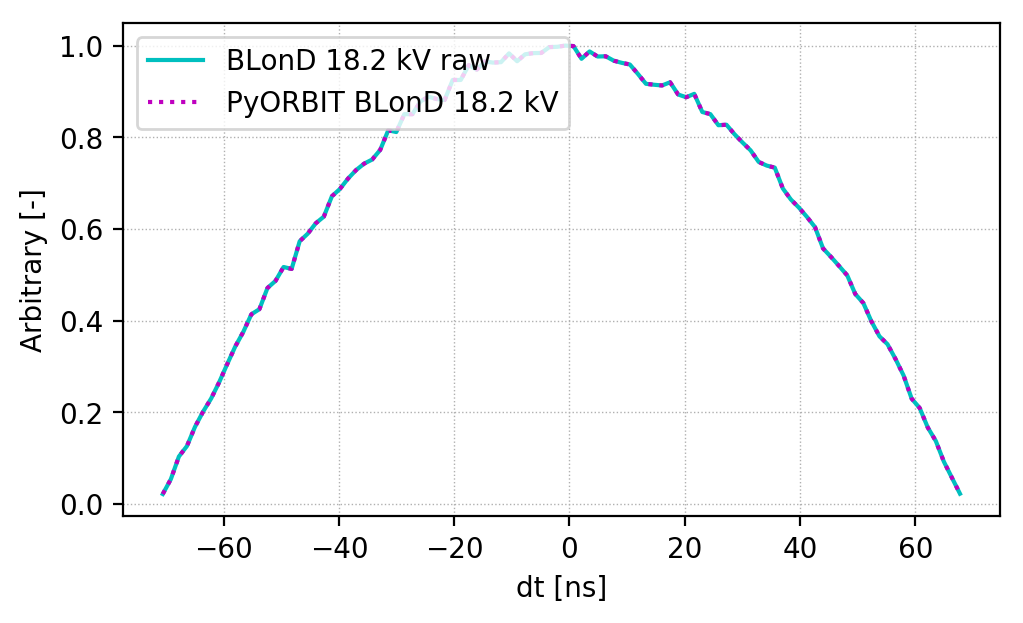

In [24]:
fig1 = plt.figure(figsize=(5, 3), dpi= 200, facecolor='w', edgecolor='k', constrained_layout=True);
ax1 = fig1.add_subplot(111);

BL2_dt_hist, BL2_dt_edges  = np.histogram(BL2_t, bins = bins_y, density=True)
norm_BL2t = 1./np.max(BL2_dt_hist);
BL2_dt_hist2 = np.multiply(BL2_dt_hist, norm_BL2t);
ax1.plot(bin_edges_to_centres(BL2_dt_edges), BL2_dt_hist2, label = 'BLonD 18.2 kV raw', color='c');

POB2_dt_hist, POB2_dt_edges  = np.histogram(POB2_t, bins = bins_y, density=True)
norm_POB2t = 1./np.max(POB2_dt_hist);
POB2_dt_hist2 = np.multiply(POB2_dt_hist, norm_POB2t);
ax1.plot(bin_edges_to_centres(POB2_dt_edges), POB2_dt_hist2, label = 'PyORBIT BLonD 18.2 kV', ls=':', color='m');  
       
ax1.set_xlabel('dt [ns]');
ax1.set_ylabel('Arbitrary [-]');
ax1.grid(which='both', ls=':', lw=0.5);
ax1.legend(loc=2);

fig1.savefig('Comparison_Plots/dt_comparison_BLonD_SC.png')

### Compare BLonD SC vs No SC matching

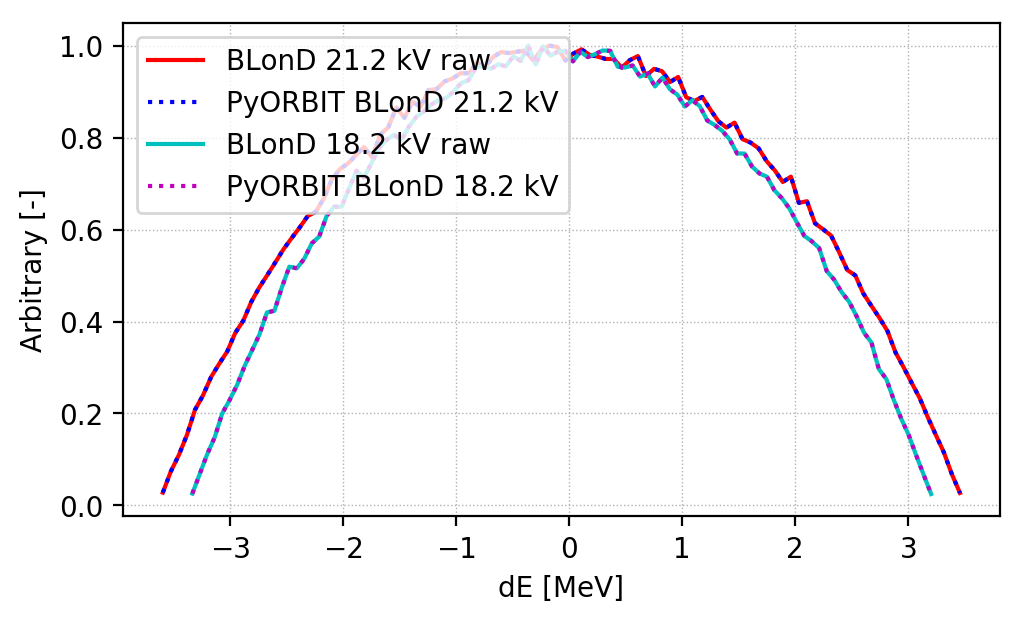

In [25]:
fig1 = plt.figure(figsize=(5, 3), dpi= 200, facecolor='w', edgecolor='k', constrained_layout=True);
ax1 = fig1.add_subplot(111);

BL_dE_hist, BL_dE_edges  = np.histogram(BL_dE, bins = bins_x, density=True)
norm_BL = 1./np.max(BL_dE_hist);
BL_dE_hist2 = np.multiply(BL_dE_hist, norm_BL);
ax1.plot(bin_edges_to_centres(BL_dE_edges), BL_dE_hist2, label = 'BLonD 21.2 kV raw', color='r'); 

POB_dE_hist, POB_dE_edges  = np.histogram(POB_dE, bins = bins_x, density=True)
norm_POB = 1./np.max(POB_dE_hist);
POB_dE_hist2 = np.multiply(POB_dE_hist, norm_POB);
ax1.plot(bin_edges_to_centres(POB_dE_edges), POB_dE_hist2, label = 'PyORBIT BLonD 21.2 kV', ls=':', color='b');  

BL2_dE_hist, BL2_dE_edges  = np.histogram(BL2_dE, bins = bins_x, density=True)
norm_BL2 = 1./np.max(BL2_dE_hist);
BL2_dE_hist2 = np.multiply(BL2_dE_hist, norm_BL2);
ax1.plot(bin_edges_to_centres(BL2_dE_edges), BL2_dE_hist2, label = 'BLonD 18.2 kV raw', color='c'); 

POB2_dE_hist, POB2_dE_edges  = np.histogram(POB2_dE, bins = bins_x, density=True)
norm_POB2 = 1./np.max(POB2_dE_hist);
POB2_dE_hist2 = np.multiply(POB2_dE_hist, norm_POB2);
ax1.plot(bin_edges_to_centres(POB2_dE_edges), POB2_dE_hist2, label = 'PyORBIT BLonD 18.2 kV', ls=':', color='m');     
         
ax1.set_xlabel('dE [MeV]');
ax1.set_ylabel('Arbitrary [-]');
ax1.grid(which='both', ls=':', lw=0.5);
ax1.legend(loc=2);

fig1.savefig('Comparison_Plots/dE_comparison_BLonD_all.png')

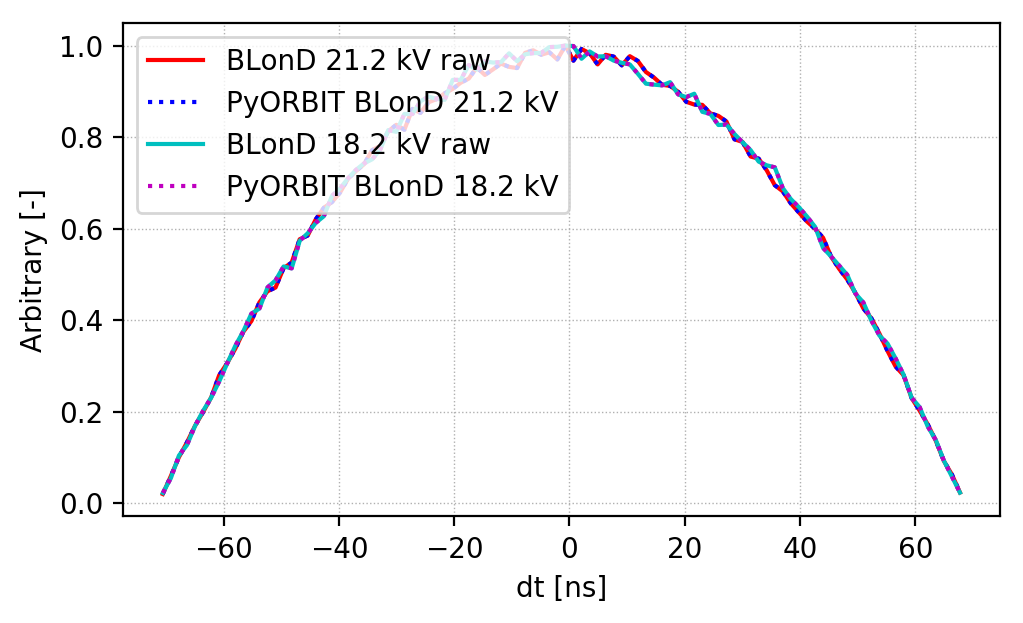

In [26]:
fig1 = plt.figure(figsize=(5, 3), dpi= 200, facecolor='w', edgecolor='k', constrained_layout=True);
ax1 = fig1.add_subplot(111);

BL_dt_hist, BL_dt_edges  = np.histogram(BL_t, bins = bins_y, density=True)
norm_BLt = 1./np.max(BL_dt_hist);
BL_dt_hist2 = np.multiply(BL_dt_hist, norm_BLt);
ax1.plot(bin_edges_to_centres(BL_dt_edges), BL_dt_hist2, label = 'BLonD 21.2 kV raw', color='r');

POB_dt_hist, POB_dt_edges  = np.histogram(POB_t, bins = bins_y, density=True)
norm_POBt = 1./np.max(POB_dt_hist);
POB_dt_hist2 = np.multiply(POB_dt_hist, norm_POBt);
ax1.plot(bin_edges_to_centres(POB_dt_edges), POB_dt_hist2, label = 'PyORBIT BLonD 21.2 kV', ls=':', color='b');  
       
BL2_dt_hist, BL2_dt_edges  = np.histogram(BL2_t, bins = bins_y, density=True)
norm_BL2t = 1./np.max(BL2_dt_hist);
BL2_dt_hist2 = np.multiply(BL2_dt_hist, norm_BL2t);
ax1.plot(bin_edges_to_centres(BL2_dt_edges), BL2_dt_hist2, label = 'BLonD 18.2 kV raw', color='c');

POB2_dt_hist, POB2_dt_edges  = np.histogram(POB2_t, bins = bins_y, density=True)
norm_POB2t = 1./np.max(POB2_dt_hist);
POB2_dt_hist2 = np.multiply(POB2_dt_hist, norm_POB2t);
ax1.plot(bin_edges_to_centres(POB2_dt_edges), POB2_dt_hist2, label = 'PyORBIT BLonD 18.2 kV', ls=':', color='m');  
       
ax1.set_xlabel('dt [ns]');
ax1.set_ylabel('Arbitrary [-]');
ax1.grid(which='both', ls=':', lw=0.5);
ax1.legend(loc=2);

fig1.savefig('Comparison_Plots/dt_comparison_BLonD_all.png')

# Plot everything

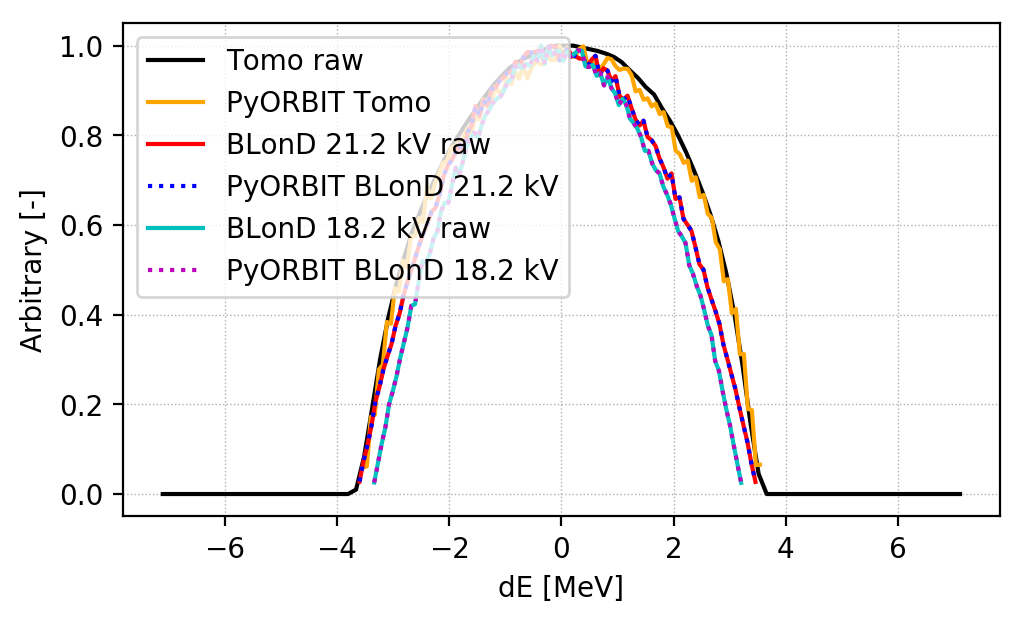

In [27]:
fig1 = plt.figure(figsize=(5, 3), dpi= 200, facecolor='w', edgecolor='k', constrained_layout=True);
ax1 = fig1.add_subplot(111);

norm = 1./np.max(dE_hist);
dE_hist2 = np.multiply(dE_hist, norm);
ax1.plot(EAxis, dE_hist2, label = 'Tomo raw', color='k'); 

PO_dE_hist, PO_dE_edges  = np.histogram(PO_dE, bins = bins_x, density=True)
norm_PO = 1./np.max(PO_dE_hist);
PO_dE_hist2 = np.multiply(PO_dE_hist, norm_PO);
ax1.plot(bin_edges_to_centres(PO_dE_edges), PO_dE_hist2, label = 'PyORBIT Tomo', color='orange'); 

BL_dE_hist, BL_dE_edges  = np.histogram(BL_dE, bins = bins_x, density=True)
norm_BL = 1./np.max(BL_dE_hist);
BL_dE_hist2 = np.multiply(BL_dE_hist, norm_BL);
ax1.plot(bin_edges_to_centres(BL_dE_edges), BL_dE_hist2, label = 'BLonD 21.2 kV raw', color='r'); 

POB_dE_hist, POB_dE_edges  = np.histogram(POB_dE, bins = bins_x, density=True)
norm_POB = 1./np.max(POB_dE_hist);
POB_dE_hist2 = np.multiply(POB_dE_hist, norm_POB);
ax1.plot(bin_edges_to_centres(POB_dE_edges), POB_dE_hist2, label = 'PyORBIT BLonD 21.2 kV', ls=':', color='b');  

BL2_dE_hist, BL2_dE_edges  = np.histogram(BL2_dE, bins = bins_x, density=True)
norm_BL2 = 1./np.max(BL2_dE_hist);
BL2_dE_hist2 = np.multiply(BL2_dE_hist, norm_BL2);
ax1.plot(bin_edges_to_centres(BL2_dE_edges), BL2_dE_hist2, label = 'BLonD 18.2 kV raw', color='c'); 

POB2_dE_hist, POB2_dE_edges  = np.histogram(POB2_dE, bins = bins_x, density=True)
norm_POB2 = 1./np.max(POB2_dE_hist);
POB2_dE_hist2 = np.multiply(POB2_dE_hist, norm_POB2);
ax1.plot(bin_edges_to_centres(POB2_dE_edges), POB2_dE_hist2, label = 'PyORBIT BLonD 18.2 kV', ls=':', color='m');     
         
ax1.set_xlabel('dE [MeV]');
ax1.set_ylabel('Arbitrary [-]');
ax1.grid(which='both', ls=':', lw=0.5);
ax1.legend(loc=2);

fig1.savefig('Comparison_Plots/dE_comparison_everything.png')

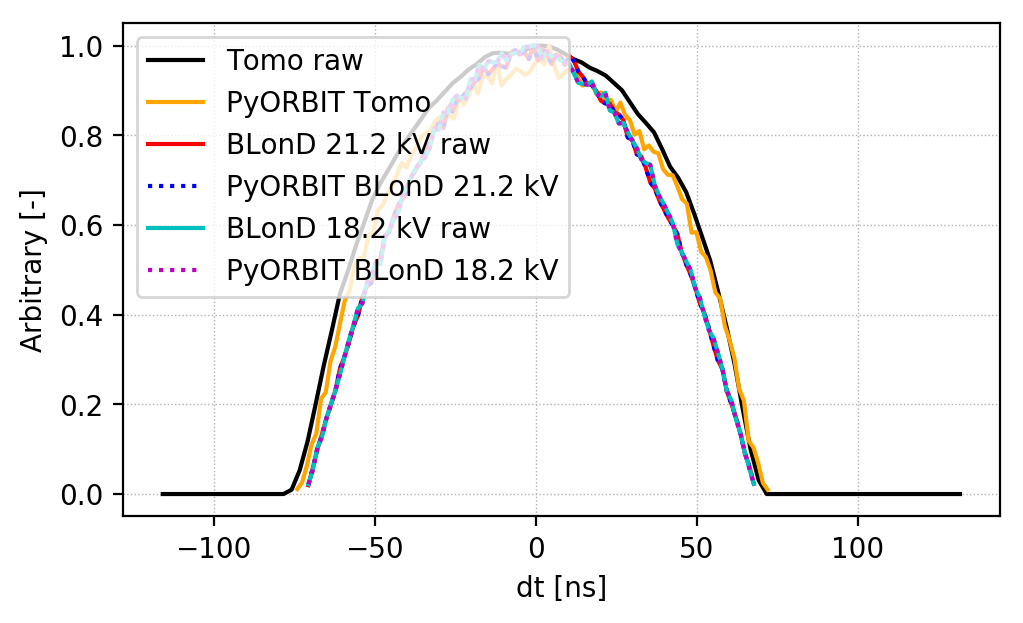

In [28]:
fig1 = plt.figure(figsize=(5, 3), dpi= 200, facecolor='w', edgecolor='k', constrained_layout=True);
ax1 = fig1.add_subplot(111);

normt = 1./np.max(dt_hist);
dt_hist2 = np.multiply(dt_hist, normt);
ax1.plot(tAxis, dt_hist2, label = 'Tomo raw', color='k');

PO_dt_hist, PO_dt_edges  = np.histogram(PO_t, bins = bins_y, density=True)
norm_POt = 1./np.max(PO_dt_hist);
PO_dt_hist2 = np.multiply(PO_dt_hist, norm_POt);
ax1.plot(bin_edges_to_centres(PO_dt_edges), PO_dt_hist2, label = 'PyORBIT Tomo', color='orange');

BL_dt_hist, BL_dt_edges  = np.histogram(BL_t, bins = bins_y, density=True)
norm_BLt = 1./np.max(BL_dt_hist);
BL_dt_hist2 = np.multiply(BL_dt_hist, norm_BLt);
ax1.plot(bin_edges_to_centres(BL_dt_edges), BL_dt_hist2, label = 'BLonD 21.2 kV raw', color='r');

POB_dt_hist, POB_dt_edges  = np.histogram(POB_t, bins = bins_y, density=True)
norm_POBt = 1./np.max(POB_dt_hist);
POB_dt_hist2 = np.multiply(POB_dt_hist, norm_POBt);
ax1.plot(bin_edges_to_centres(POB_dt_edges), POB_dt_hist2, label = 'PyORBIT BLonD 21.2 kV', ls=':', color='b');  
       
BL2_dt_hist, BL2_dt_edges  = np.histogram(BL2_t, bins = bins_y, density=True)
norm_BL2t = 1./np.max(BL2_dt_hist);
BL2_dt_hist2 = np.multiply(BL2_dt_hist, norm_BL2t);
ax1.plot(bin_edges_to_centres(BL2_dt_edges), BL2_dt_hist2, label = 'BLonD 18.2 kV raw', color='c');

POB2_dt_hist, POB2_dt_edges  = np.histogram(POB2_t, bins = bins_y, density=True)
norm_POB2t = 1./np.max(POB2_dt_hist);
POB2_dt_hist2 = np.multiply(POB2_dt_hist, norm_POB2t);
ax1.plot(bin_edges_to_centres(POB2_dt_edges), POB2_dt_hist2, label = 'PyORBIT BLonD 18.2 kV', ls=':', color='m');  
       
ax1.set_xlabel('dt [ns]');
ax1.set_ylabel('Arbitrary [-]');
ax1.grid(which='both', ls=':', lw=0.5);
ax1.legend(loc=2);

fig1.savefig('Comparison_Plots/dt_comparison_BLonD_all.png')